In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
from scipy.stats import chi2_contingency as chi2_contingency
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn import decomposition
import time
from sklearn.model_selection import KFold
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import prediction_error
from sklearn.model_selection import learning_curve

In [2]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import *
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import t, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from yellowbrick.regressor import ResidualsPlot

In [3]:
from sklearn.dummy import DummyRegressor

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix

In [6]:
from sklearn.linear_model import LinearRegression 

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
pd.set_option('display.max_columns', 46);
pd.set_option('display.max_rows', 100)


In [9]:
df = pd.read_csv('projet_4_clean.csv',index_col=[0], )

In [10]:
df.shape

(1533, 31)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1533 entries, 252 to 2070
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   BuildingType                 1533 non-null   object 
 1   PrimaryPropertyType          1533 non-null   object 
 2   YearBuilt                    1533 non-null   int64  
 3   NumberofBuildings            1533 non-null   int64  
 4   NumberofFloors               1533 non-null   int64  
 5   PropertyGFATotal             1533 non-null   int64  
 6   PropertyGFAParking           1533 non-null   int64  
 7   PropertyGFABuilding(s)       1533 non-null   int64  
 8   YearsENERGYSTARCertified     97 non-null     float64
 9   ENERGYSTARScore              1533 non-null   float64
 10  SiteEnergyUse                1533 non-null   float64
 11  SteamUse(kBtu)               1533 non-null   float64
 12  Electricity(kBtu)            1533 non-null   float64
 13  NaturalGas(kBtu)

# Préparation des données

<Figure size 800x550 with 0 Axes>

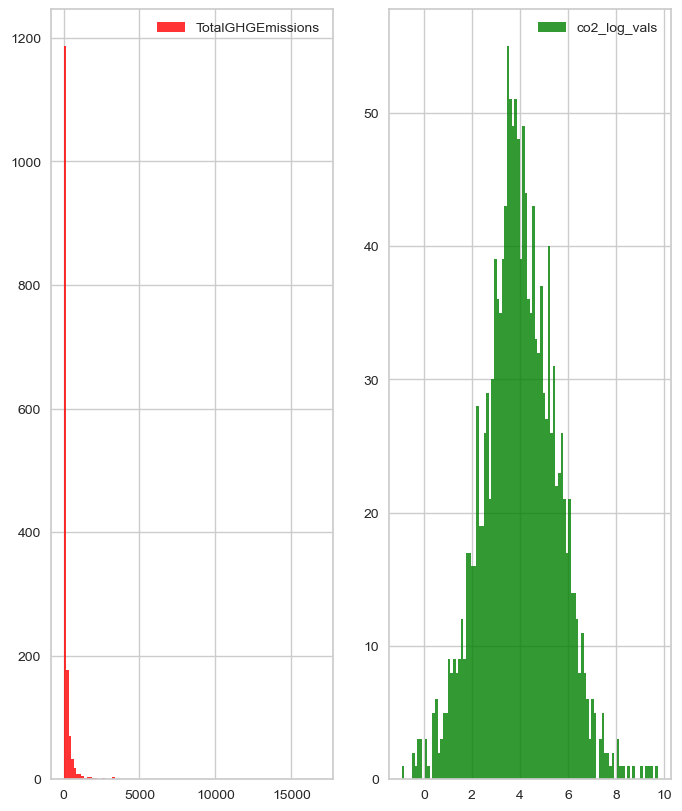

In [12]:
# Comparaison avec log
df1 = df.copy()
df1['co2_log_vals'] = np.log(df1['TotalGHGEmissions'])
plt.figure()
fig, ax = plt.subplots(1,2,figsize=(8,10))
df1['co2_log_vals'].hist(bins=100, alpha=0.8, legend=True,ax=ax[1],color='green')
df1['TotalGHGEmissions'].hist(bins=100, alpha=0.8,legend=True,ax=ax[0],color='red')
plt.show()


In [13]:
df1[['co2_log_vals','TotalGHGEmissions']]

,co2_log_vals,TotalGHGEmissions
252,3.829293,46.03
554,4.786908,119.93
428,4.511958,91.10
293,5.377267,216.43
551,4.220390,68.06
...,...,...
1620,4.211387,67.45
1621,2.193886,8.97
1622,2.504709,12.24
1567,3.533978,34.26


In [13]:
df_clean = df1[['YearBuilt', 'NumberofBuildings','SteamUse(kBtu)',
       'NaturalGas(kBtu)',  'Autres', 'Education',
       'EntertainmentPublicAssembly', 'FoodSalesService', 'Healthcare',
       'LodgingResidential', 'Office', 'Other', 'Parking', 'ReligiousWorship',
       'Retail', 'TechnologyScience', 'WarehouseStorage','Outlier','TotalGHGEmissions','co2_log_vals']]

In [14]:
df_star = df1[['YearBuilt', 'NumberofBuildings', 'SteamUse(kBtu)',
       'NaturalGas(kBtu)',  'Autres', 'Education',
       'EntertainmentPublicAssembly', 'FoodSalesService', 'Healthcare',
       'LodgingResidential', 'Office', 'Other', 'Parking', 'ReligiousWorship',
       'Retail', 'TechnologyScience', 'WarehouseStorage','ENERGYSTARScore','Outlier','TotalGHGEmissions','co2_log_vals']]

## Sélection de modèles

In [15]:
# Modèles sélectionnés:
dummy_reg = DummyRegressor()
lin_reg = LinearRegression()
ridge = Ridge(random_state=0)
lasso = Lasso(random_state=0)
dec_tree =  DecisionTreeRegressor(random_state=0)
svr = SVR()# Support Vector Regression
adaboost = AdaBoostRegressor(random_state=0)
bagging = BaggingRegressor(random_state=0)
gradientboosting = GradientBoostingRegressor()
forest = RandomForestRegressor(random_state=0)
xgboost = xgb.XGBRegressor(random_state=0)
Knregressor = KNeighborsRegressor()

# Evaluation des différents modèles de regression

Comparaison des méthodes
Pour la comparaison des methodes on vas baser sur :

Le RMSE (root mean squared error) fournit une indication sur la variance du modèle prédit. Plus précisément, il caractérise la taille des écarts entre observations et les mesures. Les valeurs du RMSE sont comprises entre [0;+∞[. Plus la valeur du critère RMSE est proche de zéro, meilleur est le modèle évalué en terme d’exactitude. Il faut donc minimiser la valeur du RMSE et choisir un modèle avec le RMSE le plus faible pour avoir un modèle qui se rapproche le plus des valeurs réelles.

MSE (Mean Square Error )Le carré moyen des erreurs : c’est la moyenne arithmétique des carrés des écarts entre prévisions du modèle et observations.C’est la valeur à minimiser dans le cadre d’une régression simple ou multiple. La méthode est fondée sur la nullité de la moyenne des résidus. Mais la moyenne de leurs carrés n'est généralement pas nulle. Cette moyenne n'est autre que la VARIANCE RÉSIDUELLE que l'on cherche à minimise

MAE (Mean Absolute Error)L’erreur absolue moyenne : moyenne arithmétique des valeurs absolues des écarts.

R2 correspond au coefficient de détermination et il s'agit du carré de la corrélation de Pearson entre les vraies valeurs et les valeurs prédites. Le coefficient de détermination nous indique donc à quel point les valeurs prédites sont corrélées aux vraies valeurs. Un modèle avec un R2 élevé prédit donc des valeurs prochent des données réelles et il est donc un bon modèle à priviléger pour notre problème. Il faut donc maximiser la valeur du R2.

In [16]:
df_clean.iloc[:,:-2].keys()

Index(['YearBuilt', 'NumberofBuildings', 'SteamUse(kBtu)', 'NaturalGas(kBtu)',
       'Autres', 'Education', 'EntertainmentPublicAssembly',
       'FoodSalesService', 'Healthcare', 'LodgingResidential', 'Office',
       'Other', 'Parking', 'ReligiousWorship', 'Retail', 'TechnologyScience',
       'WarehouseStorage', 'Outlier'],
      dtype='object')

In [17]:
# Création d'un dictionnaire de modèle
models = {'dummy_reg': DummyRegressor(),
    'lin_reg': LinearRegression(),
    'ridge' : Ridge(random_state=0),
    'lasso' : Lasso(random_state=0),
    'dec_tree':  DecisionTreeRegressor(random_state=0),
    'svr' : SVR(),
    'adaboost' :AdaBoostRegressor(random_state=0),
    'bagging ': BaggingRegressor(random_state=0),
    'gradientboosting': GradientBoostingRegressor(),
    'forest' : RandomForestRegressor(random_state=0),
    'xgboost' : xgb.XGBRegressor(random_state=0),
    'Knregressor' : KNeighborsRegressor()}

In [18]:
def evaluation_model(df,models,log=False,Outlier=True):
    if (log == True) & (Outlier == True):
        X = df.iloc[:,:-2].values
        y = df['co2_log_vals'].values
        name = df.iloc[:,:-2].keys()
    elif (log == True) & (Outlier == False): 
        df = df.drop(df.loc[df['Outlier']==1].index)
        X = df.iloc[:,:-3].values
        y = df['co2_log_vals'].values
        name = df.iloc[:,:-3].keys()
    elif (log == False) & (Outlier == False): 
        df = df.drop(df.loc[df['Outlier']==1].index)
        X = df.iloc[:,:-3].values
        y = df['TotalGHGEmissions'].values
        name = df.iloc[:,:-3].keys()
    elif (log == False) & (Outlier == True): 
        X = df.iloc[:,:-2].values
        y = df['TotalGHGEmissions'].values
        name = df.iloc[:,:-2].keys()
    else:  
        pass
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    
    df_modele =  pd.DataFrame(columns=['Modèle','Standardisation','Log','Outlier','MAE','MSE','RMSE','R2_train','Time_train','R2_predict','Time_predict'])

    for standardisers in [('StandardScaler', StandardScaler()),('MinMaxScaler', MinMaxScaler()),('RobustScaler', RobustScaler())]:
        
        scaler = standardisers[1]
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        
        results = []
        for i, model in enumerate(models):
            clf = models[model]
            clf.fit(X_train, y_train)
            # Calcul du temps d'entraînement
            start_time_train = time.time()
            r2_train = clf.score(X_train,y_train)
            time_end_train = time.time()
            # fin d'exécution

            # Calcul du temps de prédiction
            start_time_pred = time.time()
            y_pred = clf.predict(X_test)
            time_end_pred = time.time()
            # fin d'exécution

            r2_predict = r2_score(y_test, y_pred)
            MAE = mean_absolute_error(y_test, y_pred)
            MSE = mean_squared_error(y_test, y_pred)
            RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
            standardisation = standardisers[1]
            log_col = log
            outlier_col = Outlier
            # durée d'exécution de l'entraînement 
            time_execution_train = time_end_train - start_time_train

            # durée d'exécution de la prédiction
            time_execution_pred = time_end_pred - start_time_pred


            results.append([model,standardisation,log_col,outlier_col,round(MAE,3),round(MSE,3),round(RMSE,3),round(r2_train,3),time_execution_train,round(r2_predict,3),time_execution_pred])
        
            essai = pd.DataFrame(results, columns=['Modèle','Standardisation','Log','Outlier','MAE','MSE','RMSE','R2_train','Time_train','R2_predict','Time_predict'])
        df_modele = pd.concat([df_modele,essai])
        df_modele = df_modele.sort_values('R2_predict',ascending=False)
        
    vif_data = pd.DataFrame()
    vif_data["feature"] = name
    #calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(X_train, i)
                          for i in range(len(name))]

    print('VIF (facteur d\'inflation de la variance)')
    print(vif_data)
    return df_modele

In [19]:
def feature_importance(df,models,log=False,Outlier=True, coef=True):
    if (log == True) & (Outlier == True):
        X = df.iloc[:,:-2].values
        y = df['co2_log_vals'].values
        name = df.iloc[:,:-2].keys()
    elif (log == True) & (Outlier == False): 
        df = df.drop(df.loc[df['Outlier']==1].index)
        X = df.iloc[:,:-3].values
        y = df['co2_log_vals'].values
        name = df.iloc[:,:-3].keys()
    elif (log == False) & (Outlier == False): 
        df = df.drop(df.loc[df['Outlier']==1].index)
        X = df.iloc[:,:-3].values
        y = df['TotalGHGEmissions'].values
        name = df.iloc[:,:-3].keys()
    elif (log == False) & (Outlier == True): 
        X = df.iloc[:,:-2].values
        y = df['TotalGHGEmissions'].values
        name = df.iloc[:,:-2].keys()
    else:  
        pass
    
    
             
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    model = models
    if coef == True :
        importance_data = pd.DataFrame()
        importance_data['features'] = name
        importance_data['coef']= model.coef_
        # plot feature importance
        sns.barplot(data=importance_data, y='features',x='coef')
        plt.show()
    elif coef == False :
        model.fit(X,y)
        importance_data = pd.DataFrame()
        importance_data['features'] = name
        importance_data['coef']= model.feature_importances_
        # plot feature importance
        sns.barplot(data=importance_data, y='features',x='coef')
        plt.show()

In [20]:
standardisers_1 = [StandardScaler(),MinMaxScaler(),RobustScaler()]

In [21]:
def predic_plot(df,model,log=False,Outlier=True,standardisers=standardisers_1[0]):
    if (log == True) & (Outlier == True):
        X = df.iloc[:,:-2].values
        y = df['co2_log_vals'].values
        name = df.iloc[:,:-2].keys()
        
    elif (log == True) & (Outlier == False): 
        
        df = df.drop(df.loc[df['Outlier']==1].index)
        X = df.iloc[:,:-3].values
        y = df['co2_log_vals'].values
        name = df.iloc[:,:-3].keys()
    
    elif (log == False) & (Outlier == False): 
        df = df.drop(df.loc[df['Outlier']==1].index)
        X = df.iloc[:,:-3].values
        y = df['TotalGHGEmissions'].values
        name = df.iloc[:,:-3].keys()
    
    else:  
        X = df.iloc[:,:-2].values
        y = df['TotalGHGEmissions'].values
        name = df.iloc[:,:-2].keys()
       
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    
    scaler = standardisers
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
        
     
    label=['y_pred','y_test']
    
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    
    r2_train = model.score(X_train,y_train)
    r2_predict = r2_score(y_test, y_pred)
    MAE = mean_absolute_error(y_test, y_pred)
    MSE = mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    print('R² train :',r2_train)
    print('R² predict:',r2_predict)
    print('MAE :',MAE)
    print('MSE :',MSE)
    print('RMSE :',RMSE)
    
    
    
    plt.plot(model.predict(X_test),y_test,'o',label=label,alpha=0.5)
    min_tru=y_test.min()
    max_tru=y_test.max()
    plt.plot([min_tru, max_tru], [min_tru, max_tru], '--') 
    plt.title('Comparaison de Y_pred et Y_test')
    plt.xlabel("Y_pred")
    plt.ylabel("Y_test")
    plt.legend(label)
    plt.show()
    
    visualizer = ResidualsPlot(model,hist=True)

    visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
    visualizer.score(X_test, y_test)  # Evaluate the model on the test data
    visualizer.show()                 # Finalize and render the figure
    
    
    visualizer = prediction_error(model, X_train, y_train, X_test, y_test)
    
    N, train_score,val_score = learning_curve(model,X_train,y_train, cv=4,train_sizes=np.linspace(0.1, 1.0, 5))
    
    plt.figure(figsize=(12,8))
    plt.title('Validation Curve')
    plt.plot(N,train_score.mean(axis=1), label= 'train score')
    plt.plot(N,val_score.mean(axis=1), label = 'validation score')
    plt.legend()
    plt.show()

In [22]:
# Evaluation des modèles sans log et avec outliers
evaluation_model(df_clean, models,log=False,Outlier=True)

VIF (facteur d'inflation de la variance)
                        feature       VIF
0                     YearBuilt  1.122042
1             NumberofBuildings  1.250383
2                SteamUse(kBtu)  1.244772
3              NaturalGas(kBtu)  1.142903
4                        Autres  1.138080
5                     Education  1.145082
6   EntertainmentPublicAssembly  1.124983
7              FoodSalesService  1.151207
8                    Healthcare  1.347765
9            LodgingResidential  1.223053
10                       Office  2.140517
11                        Other  1.206840
12                      Parking  1.921515
13             ReligiousWorship  1.008908
14                       Retail  1.153047
15            TechnologyScience  1.109145
16             WarehouseStorage  1.029342
17                      Outlier  2.294685


,Modèle,Standardisation,Log,Outlier,MAE,MSE,RMSE,R2_train,Time_train,R2_predict,Time_predict
1,lin_reg,StandardScaler(),False,True,157.493,714262.094,845.140,0.804,0.000000,0.556,0.000000
2,ridge,StandardScaler(),False,True,157.496,715065.754,845.616,0.804,0.000000,0.556,0.000000
1,lin_reg,RobustScaler(),False,True,157.493,714262.094,845.140,0.804,0.000000,0.556,0.000000
1,lin_reg,MinMaxScaler(),False,True,157.493,714262.094,845.140,0.804,0.000000,0.556,0.000000
3,lasso,StandardScaler(),False,True,156.944,731005.756,854.989,0.804,0.000000,0.546,0.000000
3,lasso,MinMaxScaler(),False,True,154.466,786705.359,886.964,0.789,0.000000,0.511,0.000000
3,lasso,RobustScaler(),False,True,155.402,802483.351,895.814,0.788,0.000000,0.501,0.000000
4,dec_tree,StandardScaler(),False,True,171.235,917466.922,957.845,1.000,0.000000,0.430,0.000000
4,dec_tree,MinMaxScaler(),False,True,170.896,917405.255,957.813,1.000,0.000000,0.430,0.000000
4,dec_tree,RobustScaler(),False,True,170.598,917257.384,957.736,1.000,0.000000,0.430,0.000000


R² train : 0.8042626261229063
R² predict: 0.55605755486463
MAE : 157.4928304021134
MSE : 714262.093511097
RMSE : 845.1402803742684


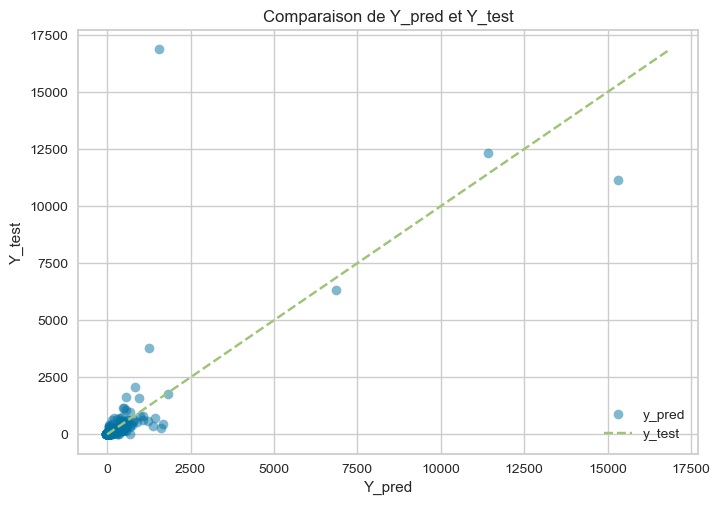

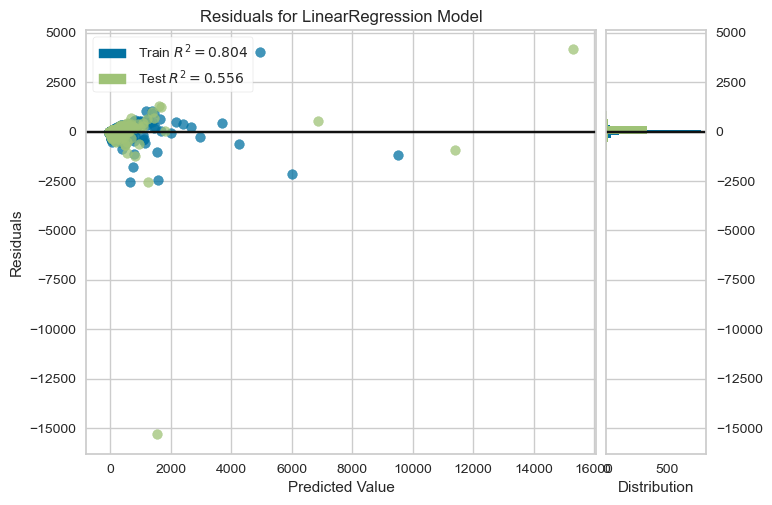

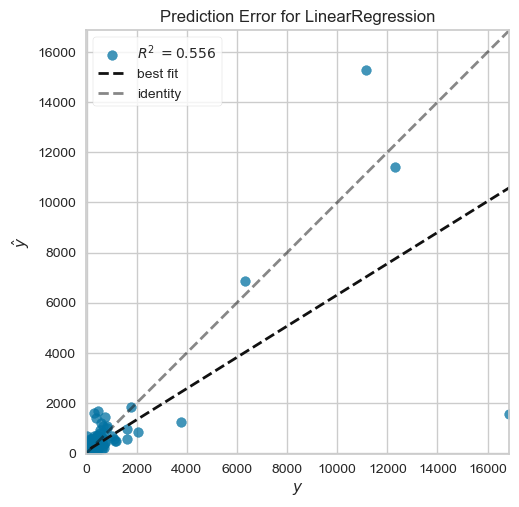

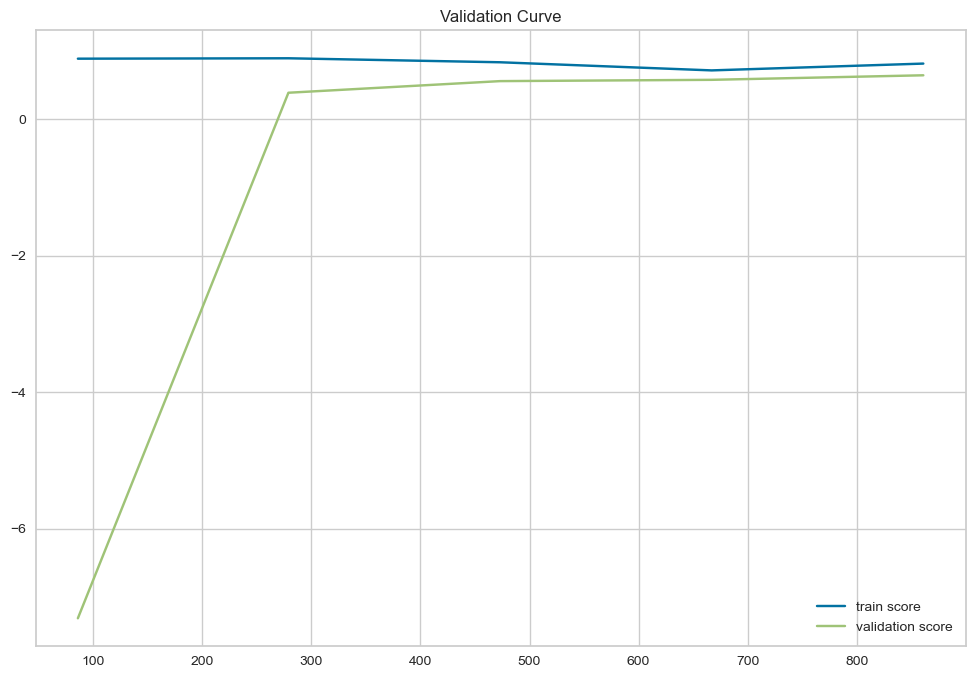

In [23]:
# Affichage du meilleur modèle
predic_plot(df_clean,models['lin_reg'],log=False,Outlier=True,standardisers=standardisers_1[0])

In [24]:
# Evaluation des modèles sans log et sans outliers
evaluation_model(df_clean, models,log=False,Outlier=False)

VIF (facteur d'inflation de la variance)
                        feature       VIF
0                     YearBuilt  1.150643
1             NumberofBuildings  1.055985
2                SteamUse(kBtu)  1.178102
3              NaturalGas(kBtu)  1.246549
4                        Autres  1.028989
5                     Education  1.011496
6   EntertainmentPublicAssembly  1.264206
7              FoodSalesService  1.040220
8                    Healthcare  1.009403
9            LodgingResidential  1.030244
10                       Office  1.638688
11                        Other  1.045421
12                      Parking  1.787590
13             ReligiousWorship  1.008743
14                       Retail  1.070557
15            TechnologyScience  1.028145
16             WarehouseStorage  1.033247


,Modèle,Standardisation,Log,Outlier,MAE,MSE,RMSE,R2_train,Time_train,R2_predict,Time_predict
9,forest,RobustScaler(),False,False,40.550,4528.335,67.293,0.909,0.015626,0.516,0.000000
9,forest,MinMaxScaler(),False,False,40.701,4546.636,67.429,0.909,0.019650,0.514,0.000000
9,forest,StandardScaler(),False,False,40.737,4558.346,67.516,0.909,0.015651,0.513,0.000000
8,gradientboosting,RobustScaler(),False,False,40.749,4701.258,68.566,0.704,0.000000,0.497,0.000000
8,gradientboosting,MinMaxScaler(),False,False,41.158,4810.311,69.356,0.704,0.000000,0.486,0.000000
8,gradientboosting,StandardScaler(),False,False,41.197,4832.409,69.516,0.704,0.000000,0.483,0.000000
7,bagging,RobustScaler(),False,False,42.373,5274.256,72.624,0.884,0.000000,0.436,0.000000
7,bagging,MinMaxScaler(),False,False,42.492,5281.192,72.672,0.884,0.000000,0.435,0.000000
7,bagging,StandardScaler(),False,False,42.655,5303.653,72.826,0.884,0.000000,0.433,0.015626
11,Knregressor,MinMaxScaler(),False,False,41.733,5320.198,72.940,0.590,0.016128,0.431,0.000000


R² train : 0.909041978982194
R² predict: 0.5158248040505191
MAE : 40.55030235294118
MSE : 4528.335289061824
RMSE : 67.29290667716639


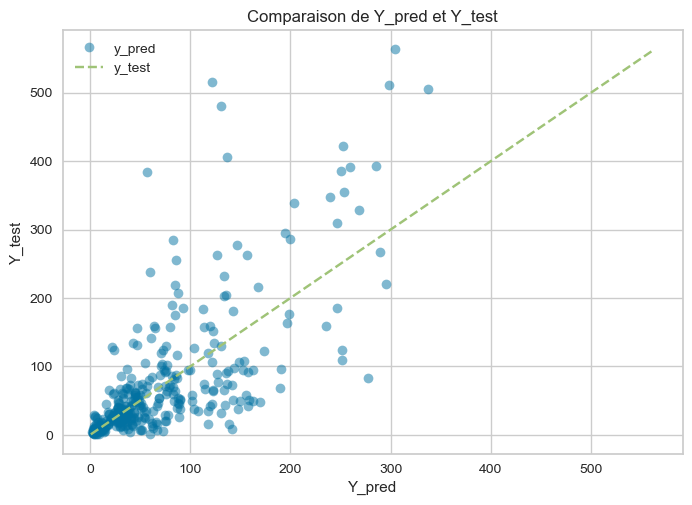

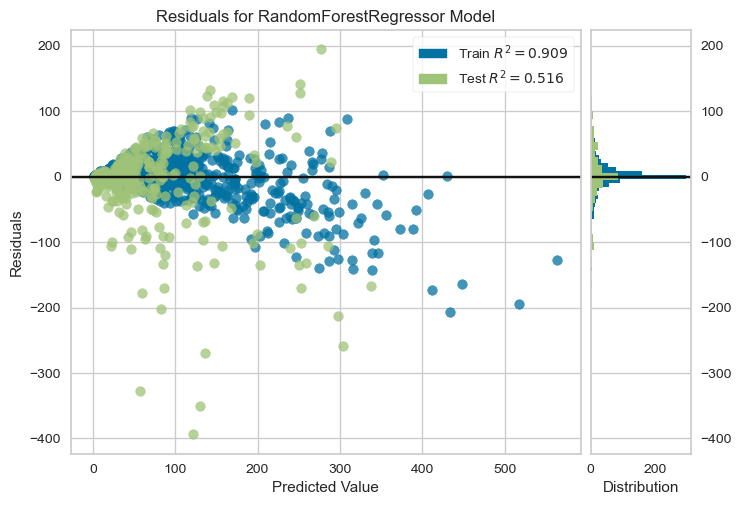

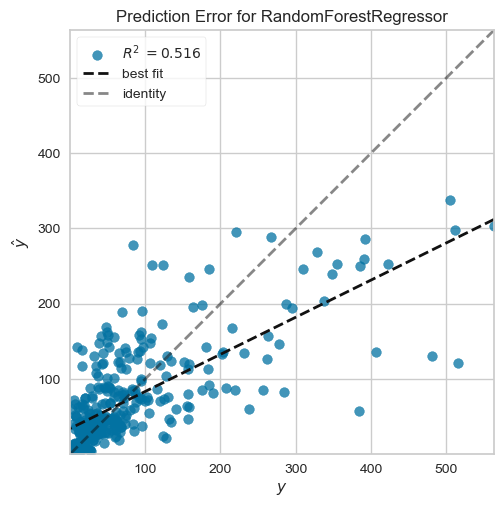

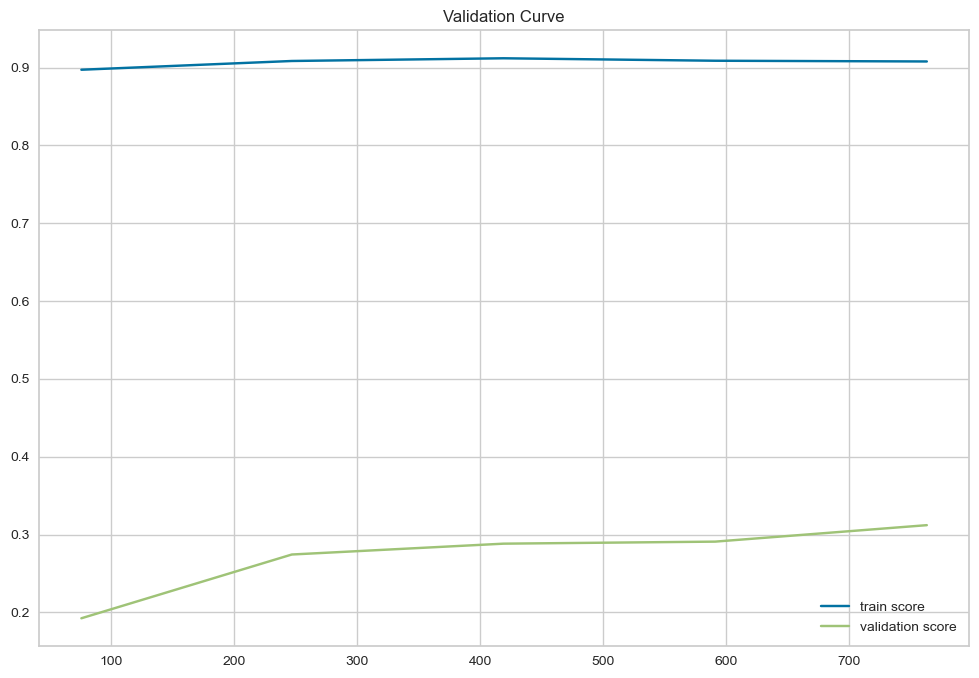

In [25]:
predic_plot(df_clean,models['forest'],log=False,Outlier=False,standardisers=standardisers_1[2])

In [26]:
# Evaluation des modèles avec log et sans outliers
evaluation_model(df_clean, models,log=True,Outlier=False)

VIF (facteur d'inflation de la variance)
                        feature       VIF
0                     YearBuilt  1.150643
1             NumberofBuildings  1.055985
2                SteamUse(kBtu)  1.178102
3              NaturalGas(kBtu)  1.246549
4                        Autres  1.028989
5                     Education  1.011496
6   EntertainmentPublicAssembly  1.264206
7              FoodSalesService  1.040220
8                    Healthcare  1.009403
9            LodgingResidential  1.030244
10                       Office  1.638688
11                        Other  1.045421
12                      Parking  1.787590
13             ReligiousWorship  1.008743
14                       Retail  1.070557
15            TechnologyScience  1.028145
16             WarehouseStorage  1.033247


,Modèle,Standardisation,Log,Outlier,MAE,MSE,RMSE,R2_train,Time_train,R2_predict,Time_predict
8,gradientboosting,StandardScaler(),True,False,0.537,0.521,0.722,0.731,0.000000,0.644,0.000000
8,gradientboosting,RobustScaler(),True,False,0.538,0.523,0.723,0.731,0.000000,0.643,0.000000
8,gradientboosting,MinMaxScaler(),True,False,0.537,0.522,0.723,0.731,0.000000,0.643,0.000000
5,svr,StandardScaler(),True,False,0.570,0.569,0.754,0.693,0.078559,0.611,0.031277
5,svr,MinMaxScaler(),True,False,0.590,0.598,0.773,0.618,0.078032,0.591,0.031278
5,svr,RobustScaler(),True,False,0.595,0.626,0.791,0.576,0.078551,0.572,0.015649
9,forest,RobustScaler(),True,False,0.612,0.628,0.793,0.943,0.016047,0.571,0.000000
9,forest,MinMaxScaler(),True,False,0.614,0.631,0.794,0.943,0.016056,0.569,0.000000
9,forest,StandardScaler(),True,False,0.614,0.633,0.796,0.943,0.016055,0.567,0.000000
11,Knregressor,MinMaxScaler(),True,False,0.624,0.645,0.803,0.709,0.015655,0.559,0.015670


R² train : 0.7314778814588556
R² predict: 0.643242461189081
MAE : 0.5373231140621944
MSE : 0.5220419733478265
RMSE : 0.7225247216170714


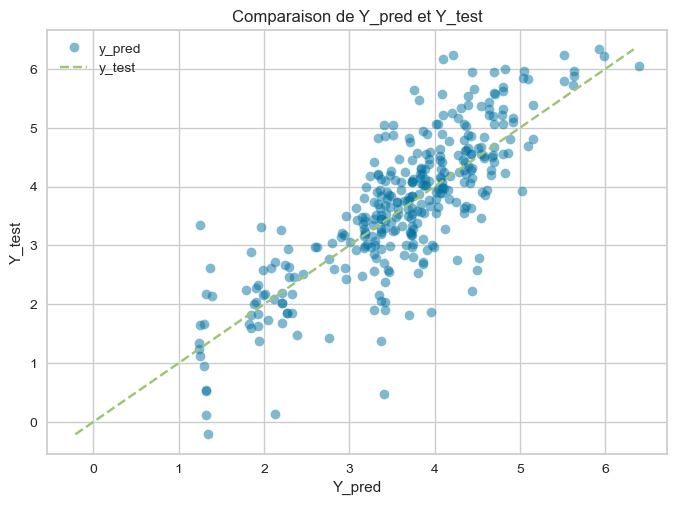

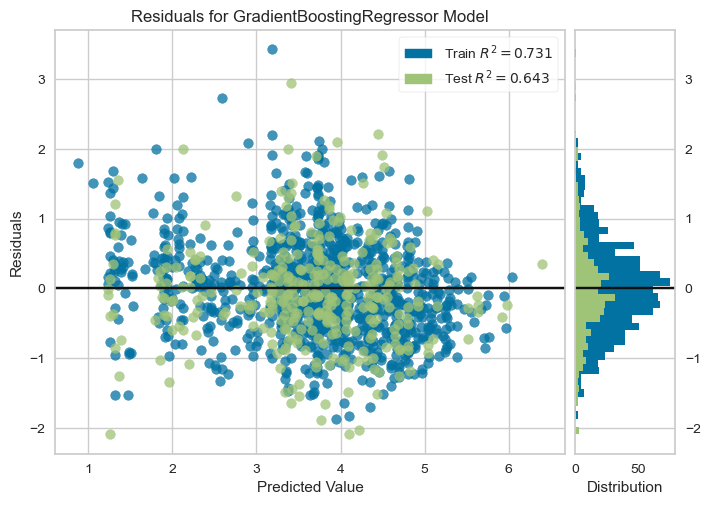

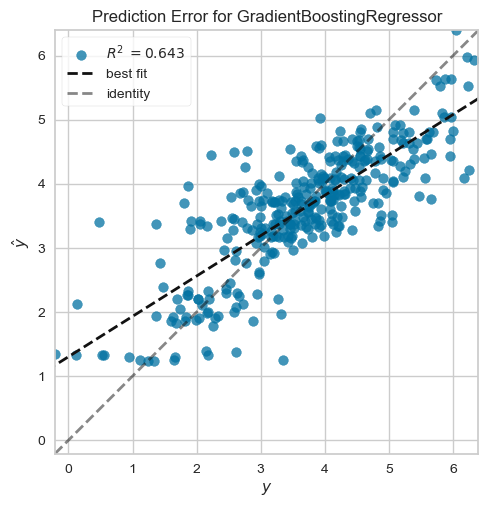

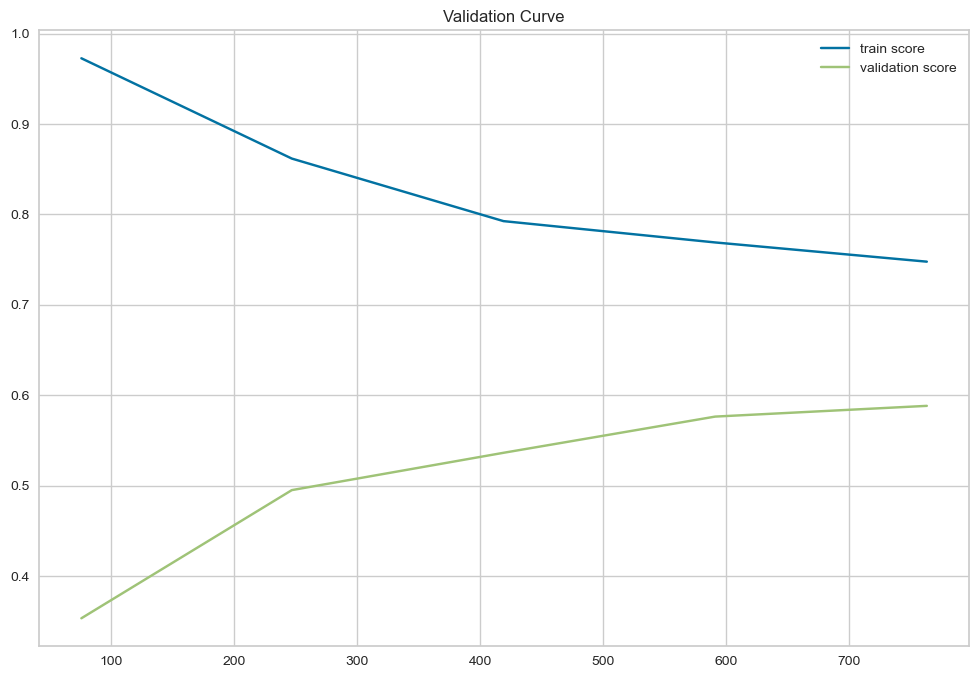

In [27]:
predic_plot(df_clean,models['gradientboosting'],log=True,Outlier=False,standardisers=standardisers_1[1])

In [28]:
# Evaluation des modèles avec log et outliers
evaluation_model(df_clean, models,log=True,Outlier=True)

VIF (facteur d'inflation de la variance)
                        feature       VIF
0                     YearBuilt  1.122042
1             NumberofBuildings  1.250383
2                SteamUse(kBtu)  1.244772
3              NaturalGas(kBtu)  1.142903
4                        Autres  1.138080
5                     Education  1.145082
6   EntertainmentPublicAssembly  1.124983
7              FoodSalesService  1.151207
8                    Healthcare  1.347765
9            LodgingResidential  1.223053
10                       Office  2.140517
11                        Other  1.206840
12                      Parking  1.921515
13             ReligiousWorship  1.008908
14                       Retail  1.153047
15            TechnologyScience  1.109145
16             WarehouseStorage  1.029342
17                      Outlier  2.294685


,Modèle,Standardisation,Log,Outlier,MAE,MSE,RMSE,R2_train,Time_train,R2_predict,Time_predict
8,gradientboosting,MinMaxScaler(),True,True,0.637,0.671,0.819,0.801,0.000000,0.730,0.000000
8,gradientboosting,StandardScaler(),True,True,0.638,0.674,0.821,0.801,0.000000,0.729,0.000000
8,gradientboosting,RobustScaler(),True,True,0.637,0.672,0.820,0.801,0.000000,0.729,0.000000
9,forest,MinMaxScaler(),True,True,0.662,0.723,0.851,0.957,0.015626,0.709,0.021370
9,forest,StandardScaler(),True,True,0.662,0.724,0.851,0.957,0.015631,0.708,0.015627
9,forest,RobustScaler(),True,True,0.663,0.724,0.851,0.957,0.015626,0.708,0.015626
7,bagging,StandardScaler(),True,True,0.662,0.729,0.854,0.944,0.015611,0.707,0.000000
7,bagging,MinMaxScaler(),True,True,0.663,0.730,0.854,0.944,0.015619,0.706,0.000000
7,bagging,RobustScaler(),True,True,0.666,0.732,0.855,0.944,0.015626,0.705,0.000000
10,xgboost,StandardScaler(),True,True,0.650,0.736,0.858,0.970,0.000000,0.704,0.000000


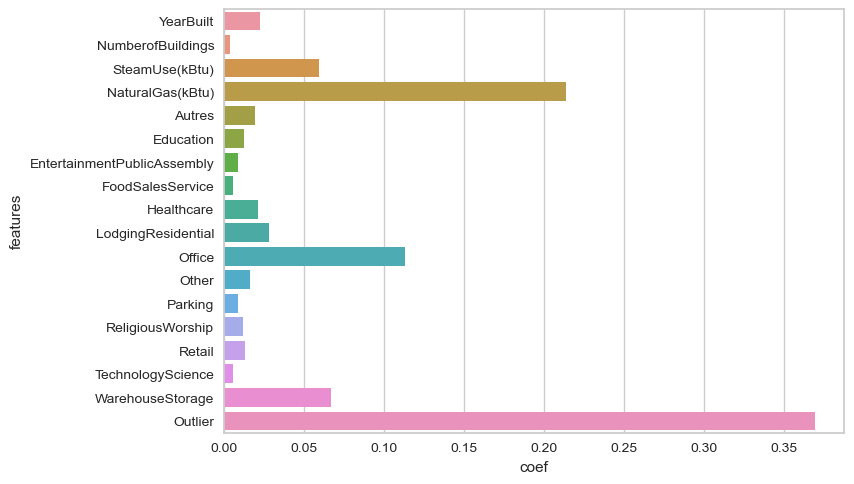

In [29]:
feature_importance(df_clean,models['gradientboosting'],log=True,Outlier=True,coef=False)

R² train : 0.8007434187610716
R² predict: 0.7287710133315546
MAE : 0.637223888268699
MSE : 0.6735248864080497
RMSE : 0.8206856197156435


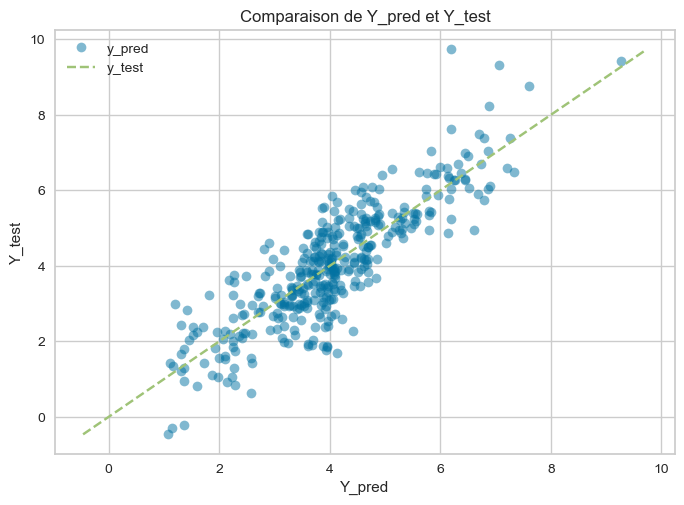

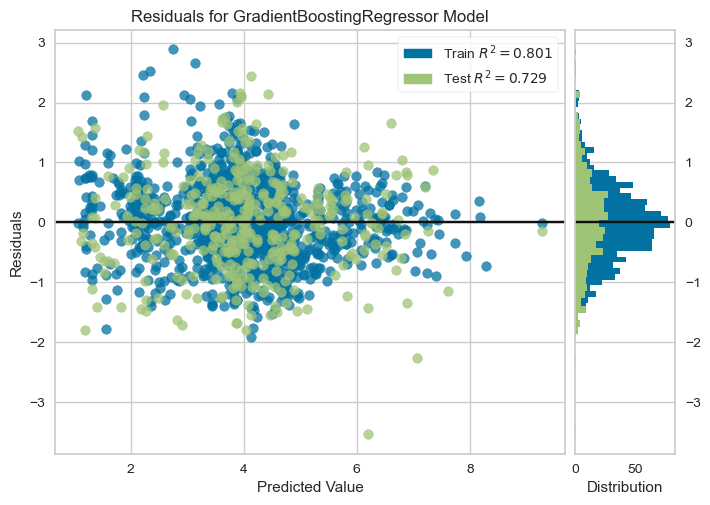

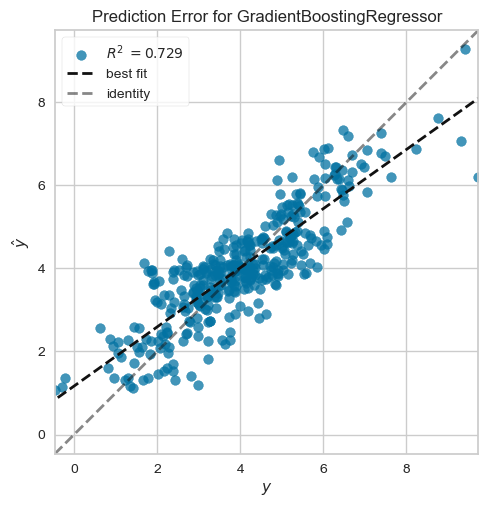

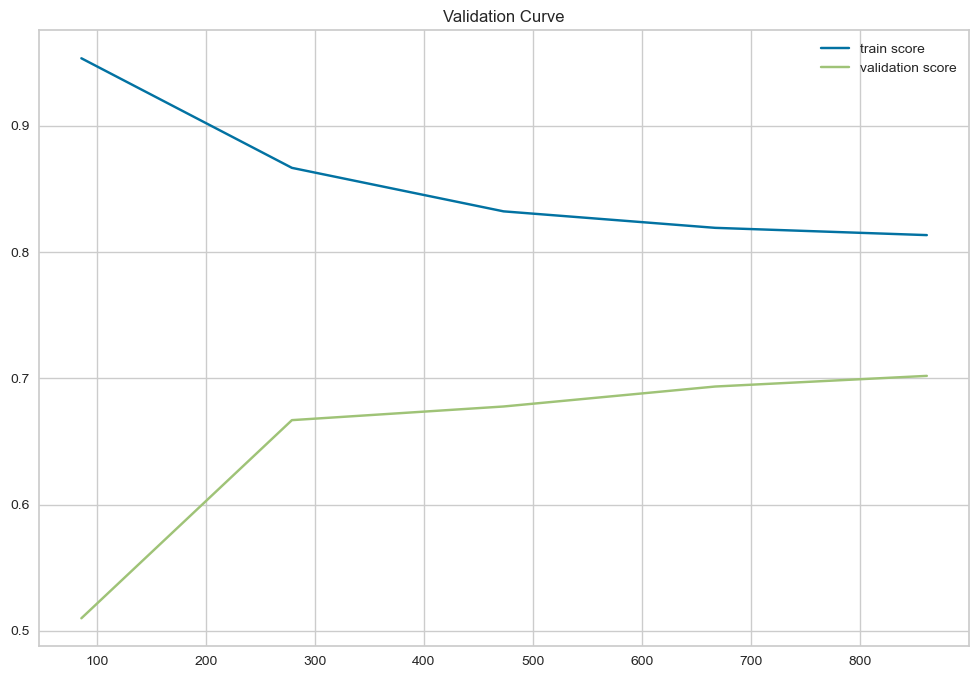

In [30]:
predic_plot(df_clean,models['gradientboosting'],log=True,Outlier=True,standardisers=standardisers_1[0])

GradientBoostingRegressor obtient le meilleur score aux tests.


# Optimisation des paramètres

In [31]:
dico_models2 ={'learning_rate': [0.01,0.02,0.03,0.04],
                  'subsample'    : [0.9, 0.5, 0.2, 0.1],
                  'n_estimators' : [100,500,1000, 1500],
                  'max_depth'    : [3,4,6]
                 }

In [32]:
def optimize_model(df,models,log=False,Outlier=True,standardisers=StandardScaler(),dico_search=dico_models2,coef=True):
    if (log == True) & (Outlier == True):
        X = df.iloc[:,:-2].values
        y = df['co2_log_vals'].values
        name = df.iloc[:,:-2].keys()
    elif (log == True) & (Outlier == False): 
        df = df.drop(df.loc[df['Outlier']==1].index)
        X = df.iloc[:,:-3].values
        y = df['co2_log_vals'].values
        name = df.iloc[:,:-3].keys()
    elif (log == False) & (Outlier == False): 
        df = df.drop(df.loc[df['Outlier']==1].index)
        X = df.iloc[:,:-3].values
        y = df['TotalGHGEmissions'].values
        name = df.iloc[:,:-3].keys()
    elif (log == False) & (Outlier == True): 
        X = df.iloc[:,:-2].values
        y = df['TotalGHGEmissions'].values
        name = df.iloc[:,:-2].keys()
    else:  
        pass
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    
    scaler = standardisers
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    #models.fit(X_train,y_train)
       
        
        
    search_grid= dico_search
    search=GridSearchCV(estimator=models,param_grid=search_grid,n_jobs=1,cv=2,verbose=1)
    search_result = search.fit(X_train,y_train)
    #param_grid = dict(alpha=param)
    #grid = GridSearchCV(estimator=models, param_grid=param_grid, verbose=1, n_jobs=-1)
    #grid_result = grid.fit(X_train, y_train)
    print('Best Params: ', search_result.best_params_)
    print('Best',search_result.best_estimator_)
    #y_pred = models.predict(X_test) 
    models = search_result.best_estimator_
    models.fit(X_train,y_train)
    y_pred = models.predict(X_test)
    
    r2_train = models.score(X_train,y_train)
    r2_predict = r2_score(y_test, y_pred)
    MAE = mean_absolute_error(y_test, y_pred)
    MSE = mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    print('R² train :',r2_train)
    print('R² predict:',r2_predict)
    print('MAE :',MAE)
    print('MSE :',MSE)
    print('RMSE :',RMSE)
    label=['y_pred','y_test']
    plt.plot(models.predict(X_test),y_test,'o',label=label,alpha=0.5)
    min_tru=y_test.min()
    max_tru=y_test.max()
    plt.plot([min_tru, max_tru], [min_tru, max_tru], '--') 
    plt.title('Comparaison de Y_pred et Y_test')
    plt.xlabel("Y_pred")
    plt.ylabel("Y_test")
    plt.legend(label)
    plt.show()
    
    visualizer = ResidualsPlot(models,hist=True)

    visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
    visualizer.score(X_test, y_test)  # Evaluate the model on the test data
    visualizer.show()                 # Finalize and render the figure
    
    
    visualizer = prediction_error(models, X_train, y_train, X_test, y_test)
    
    N, train_score,val_score = learning_curve(models,X_train,y_train, cv=4,train_sizes=np.linspace(0.1, 1.0, 5))
    
    plt.figure(figsize=(12,8))
    plt.title('Validation Curve')
    plt.plot(N,train_score.mean(axis=1), label= 'train score')
    plt.plot(N,val_score.mean(axis=1), label = 'validation score')
    plt.legend()
    plt.show()
    
    model = models
    if coef == True :
        importance_data = pd.DataFrame()
        importance_data['features'] = name
        importance_data['coef']= model.coef_
        # plot feature importance
        sns.barplot(data=importance_data, y='features',x='coef')
        plt.show()
    elif coef == False :
        model.fit(X,y)
        importance_data = pd.DataFrame()
        importance_data['features'] = name
        importance_data['coef']= model.feature_importances_
        # plot feature importance
        sns.barplot(data=importance_data, y='features',x='coef')
        plt.show()

Fitting 2 folds for each of 192 candidates, totalling 384 fits
Best Params:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.5}
Best GradientBoostingRegressor(learning_rate=0.01, n_estimators=1000, subsample=0.5)
R² train : 0.8048836826209074
R² predict: 0.7416930796805887
MAE : 0.6252273696393887
MSE : 0.6414363792879406
RMSE : 0.8008972339120298


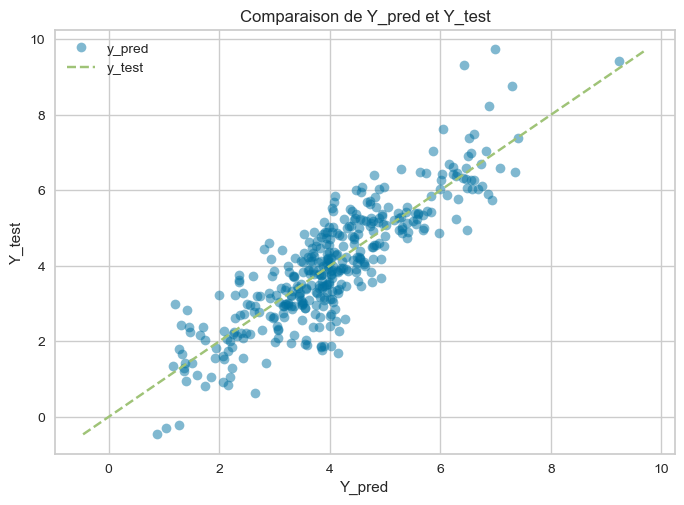

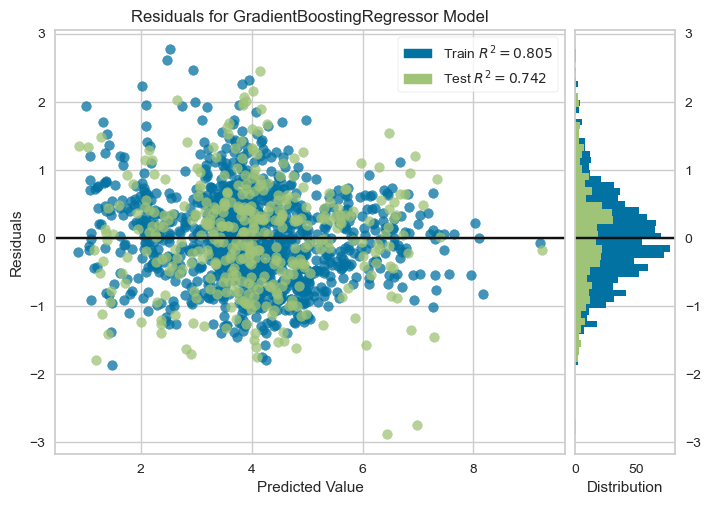

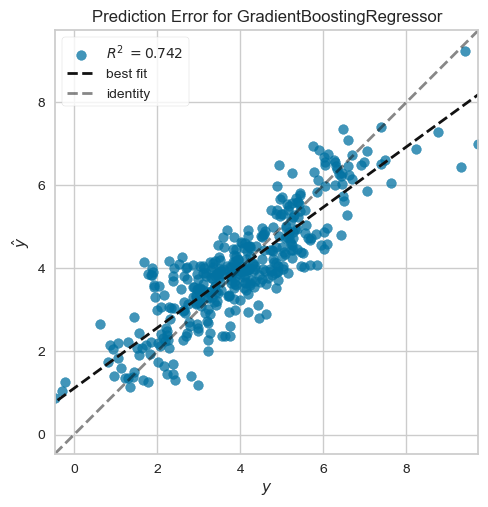

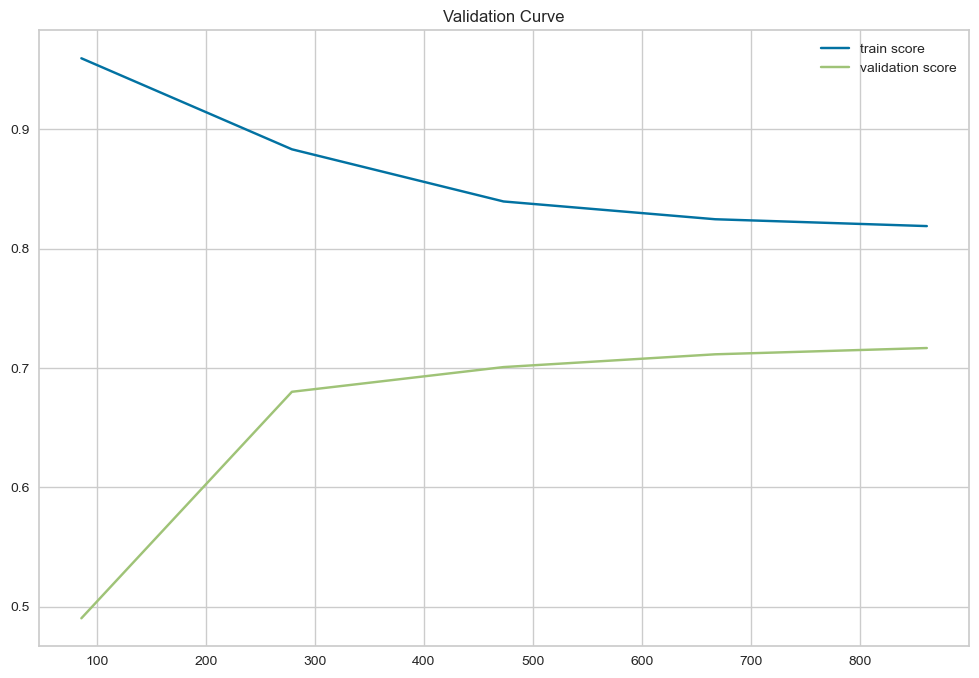

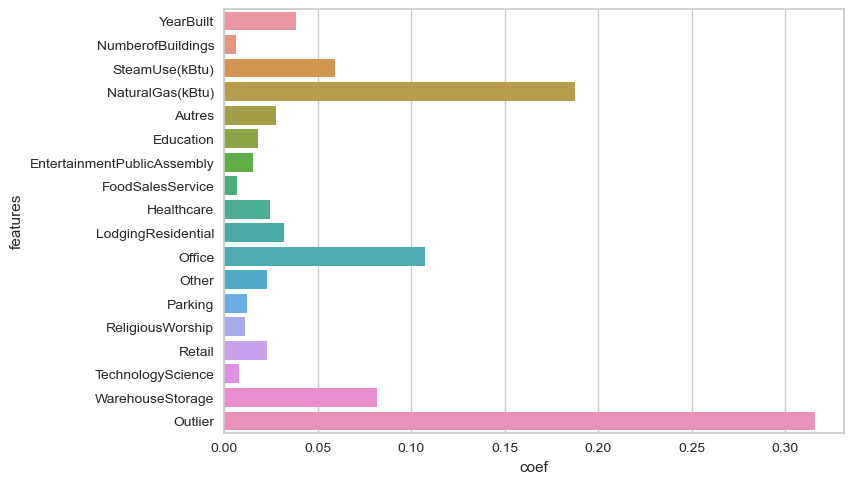

In [33]:
optimize_model(df_clean,models['gradientboosting'],log=True,Outlier=True,standardisers=StandardScaler(),dico_search=dico_models2,coef=False)

# Modèle avec EnergieScore

In [34]:
# Evaluation des modèles sans log et avec outliers
evaluation_model(df_star, models,log=False,Outlier=True)

VIF (facteur d'inflation de la variance)
                        feature       VIF
0                     YearBuilt  1.124374
1             NumberofBuildings  1.250406
2                SteamUse(kBtu)  1.244772
3              NaturalGas(kBtu)  1.143950
4                        Autres  1.141118
5                     Education  1.146261
6   EntertainmentPublicAssembly  1.125435
7              FoodSalesService  1.151466
8                    Healthcare  1.353308
9            LodgingResidential  1.223478
10                       Office  2.201915
11                        Other  1.208193
12                      Parking  1.924629
13             ReligiousWorship  1.011615
14                       Retail  1.154504
15            TechnologyScience  1.109357
16             WarehouseStorage  1.030728
17              ENERGYSTARScore  1.075246
18                      Outlier  2.334496


,Modèle,Standardisation,Log,Outlier,MAE,MSE,RMSE,R2_train,Time_train,R2_predict,Time_predict
1,lin_reg,StandardScaler(),False,True,156.808,706974.689,840.818,0.805,0.000000,0.561,0.000000
1,lin_reg,RobustScaler(),False,True,156.808,706974.689,840.818,0.805,0.000000,0.561,0.000000
1,lin_reg,MinMaxScaler(),False,True,156.808,706974.689,840.818,0.805,0.000000,0.561,0.000000
2,ridge,StandardScaler(),False,True,156.811,707777.395,841.295,0.805,0.000000,0.560,0.000000
3,lasso,StandardScaler(),False,True,156.346,724061.436,850.918,0.805,0.005027,0.550,0.000000
3,lasso,MinMaxScaler(),False,True,153.438,784204.063,885.553,0.789,0.000000,0.513,0.000000
3,lasso,RobustScaler(),False,True,154.351,797233.844,892.880,0.789,0.000000,0.504,0.000000
2,ridge,MinMaxScaler(),False,True,173.151,935511.113,967.218,0.743,0.000000,0.419,0.000000
2,ridge,RobustScaler(),False,True,173.499,941147.000,970.127,0.742,0.000000,0.415,0.000000
8,gradientboosting,StandardScaler(),False,True,165.247,957305.769,978.420,0.975,0.001000,0.405,0.000000


R² train : 0.8053216206925113
R² predict: 0.5605869678386654
MAE : 156.8083097671117
MSE : 706974.6894147749
RMSE : 840.8178693479194


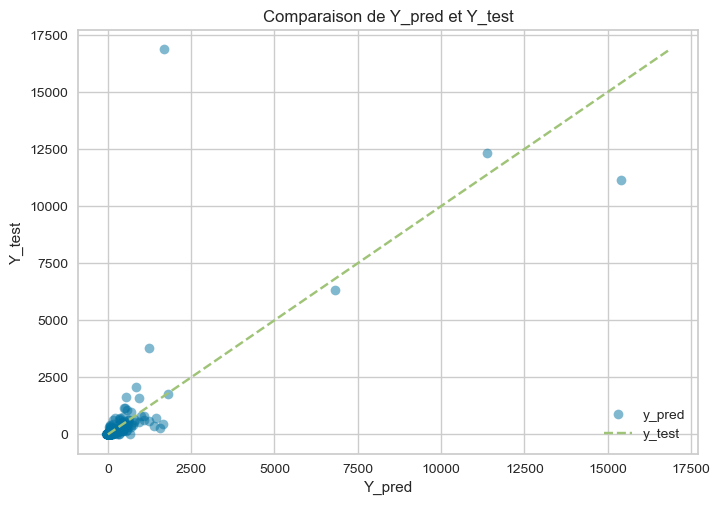

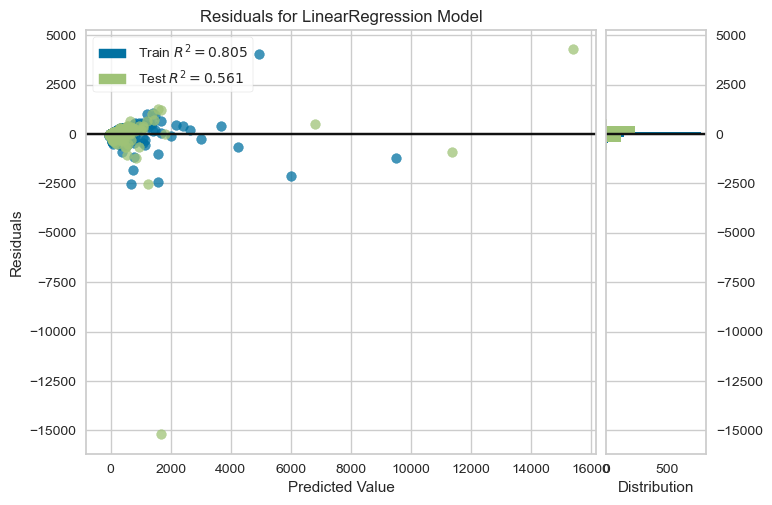

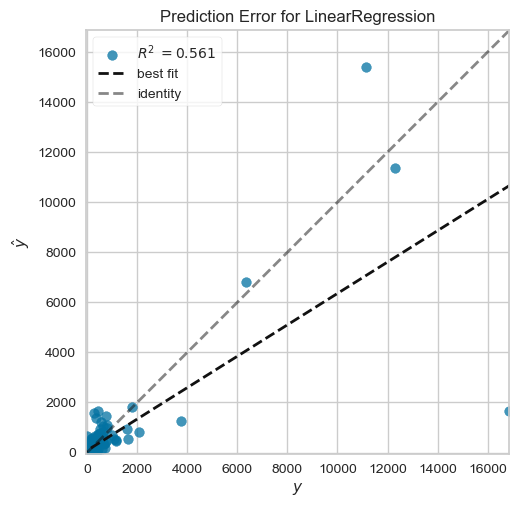

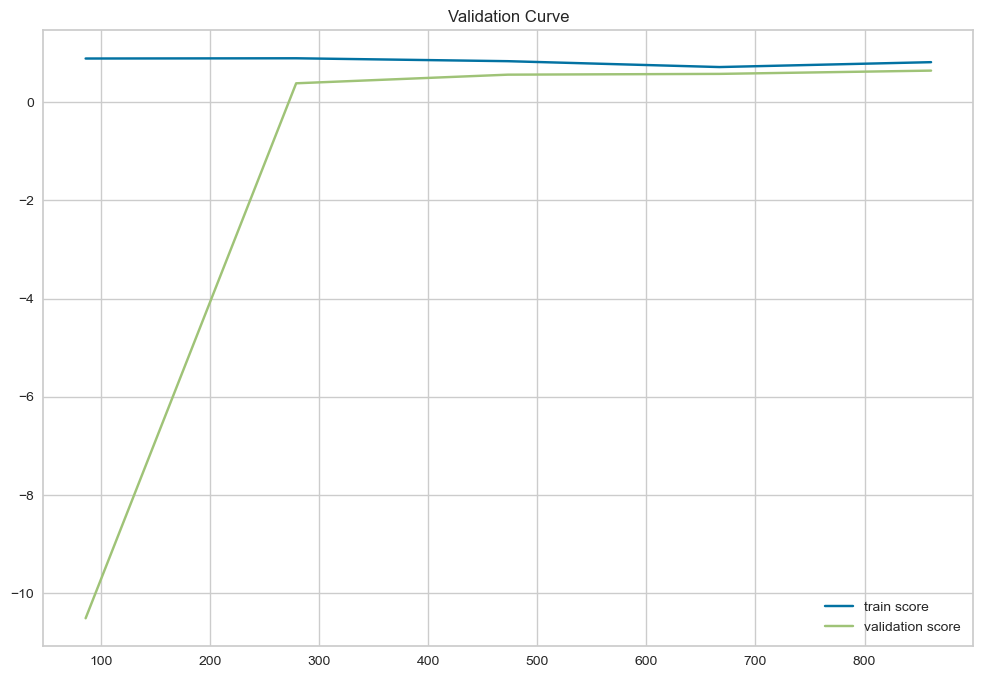

In [35]:
# Affichage du meilleur modèle
predic_plot(df_star,models['lin_reg'],log=False,Outlier=True,standardisers=standardisers_1[0])

In [36]:
# Evaluation des modèles sans log et sans outliers
evaluation_model(df_star, models,log=False,Outlier=False)

VIF (facteur d'inflation de la variance)
                        feature       VIF
0                     YearBuilt  1.156720
1             NumberofBuildings  1.056277
2                SteamUse(kBtu)  1.178213
3              NaturalGas(kBtu)  1.249512
4                        Autres  1.029540
5                     Education  1.025051
6   EntertainmentPublicAssembly  1.264275
7              FoodSalesService  1.042593
8                    Healthcare  1.010250
9            LodgingResidential  1.030582
10                       Office  1.693129
11                        Other  1.045575
12                      Parking  1.788327
13             ReligiousWorship  1.009194
14                       Retail  1.070776
15            TechnologyScience  1.029387
16             WarehouseStorage  1.033247
17              ENERGYSTARScore  1.069324


,Modèle,Standardisation,Log,Outlier,MAE,MSE,RMSE,R2_train,Time_train,R2_predict,Time_predict
9,forest,StandardScaler(),False,False,39.258,4452.354,66.726,0.917,0.007435,0.524,0.015643
9,forest,RobustScaler(),False,False,39.256,4449.854,66.707,0.917,0.017004,0.524,0.009053
9,forest,MinMaxScaler(),False,False,39.314,4455.659,66.751,0.917,0.016057,0.524,0.000000
8,gradientboosting,StandardScaler(),False,False,41.262,4823.645,69.452,0.738,0.000000,0.484,0.000000
8,gradientboosting,RobustScaler(),False,False,41.382,4919.842,70.142,0.738,0.000000,0.474,0.000000
8,gradientboosting,MinMaxScaler(),False,False,41.608,4950.648,70.361,0.738,0.000000,0.471,0.000000
7,bagging,RobustScaler(),False,False,41.172,5001.661,70.722,0.897,0.000000,0.465,0.000000
7,bagging,MinMaxScaler(),False,False,41.277,5032.070,70.937,0.898,0.003001,0.462,0.001000
7,bagging,StandardScaler(),False,False,41.364,5050.592,71.068,0.898,0.008125,0.460,0.000000
11,Knregressor,StandardScaler(),False,False,43.717,5513.959,74.256,0.585,0.012155,0.410,0.013006


R² train : 0.9167042739599545
R² predict: 0.5239488549395748
MAE : 39.25828382352942
MSE : 4452.353647212324
RMSE : 66.72595932028497


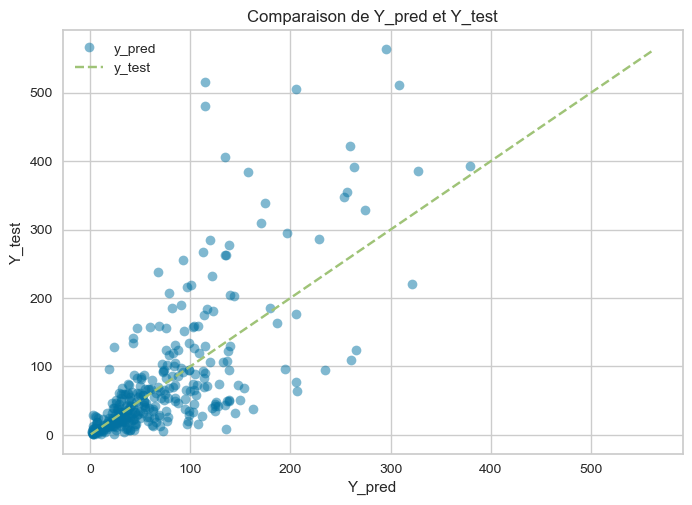

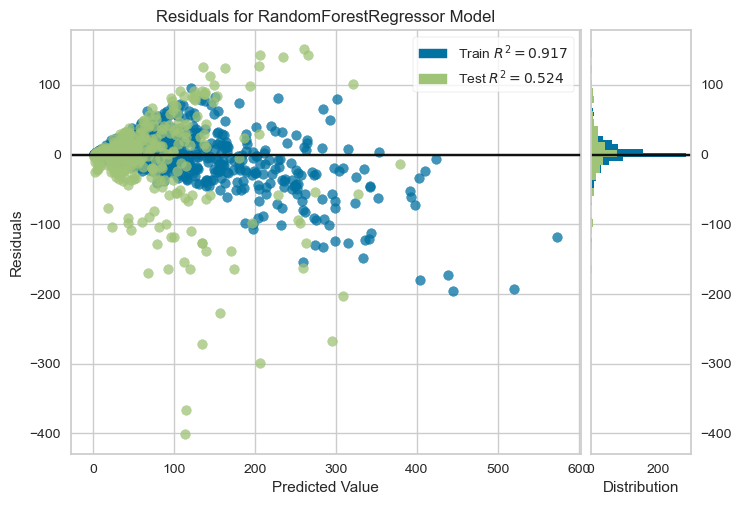

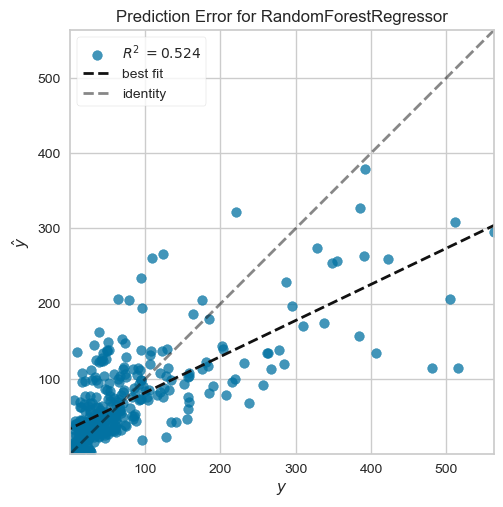

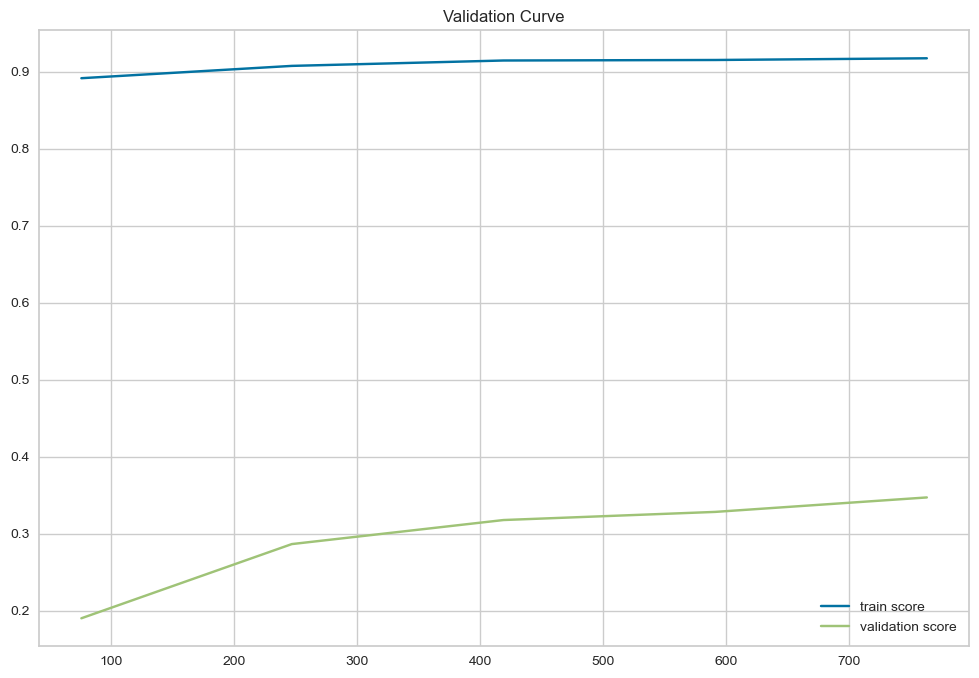

In [37]:
predic_plot(df_star,models['forest'],log=False,Outlier=False,standardisers=standardisers_1[0])

In [38]:
# Evaluation des modèles avec log et sans outliers
evaluation_model(df_star, models,log=True,Outlier=False)

VIF (facteur d'inflation de la variance)
                        feature       VIF
0                     YearBuilt  1.156720
1             NumberofBuildings  1.056277
2                SteamUse(kBtu)  1.178213
3              NaturalGas(kBtu)  1.249512
4                        Autres  1.029540
5                     Education  1.025051
6   EntertainmentPublicAssembly  1.264275
7              FoodSalesService  1.042593
8                    Healthcare  1.010250
9            LodgingResidential  1.030582
10                       Office  1.693129
11                        Other  1.045575
12                      Parking  1.788327
13             ReligiousWorship  1.009194
14                       Retail  1.070776
15            TechnologyScience  1.029387
16             WarehouseStorage  1.033247
17              ENERGYSTARScore  1.069324


,Modèle,Standardisation,Log,Outlier,MAE,MSE,RMSE,R2_train,Time_train,R2_predict,Time_predict
8,gradientboosting,StandardScaler(),True,False,0.525,0.475,0.689,0.771,0.001000,0.675,0.000000
8,gradientboosting,RobustScaler(),True,False,0.525,0.475,0.690,0.771,0.001000,0.675,0.000000
8,gradientboosting,MinMaxScaler(),True,False,0.526,0.476,0.690,0.771,0.000000,0.675,0.000000
5,svr,StandardScaler(),True,False,0.546,0.519,0.720,0.746,0.084460,0.646,0.025059
5,svr,MinMaxScaler(),True,False,0.599,0.591,0.769,0.656,0.065833,0.596,0.036549
9,forest,RobustScaler(),True,False,0.596,0.593,0.770,0.950,0.019108,0.595,0.002000
9,forest,StandardScaler(),True,False,0.597,0.594,0.771,0.950,0.015627,0.594,0.019307
9,forest,MinMaxScaler(),True,False,0.597,0.594,0.771,0.950,0.010026,0.594,0.015652
7,bagging,RobustScaler(),True,False,0.603,0.598,0.773,0.937,0.000000,0.592,0.000000
7,bagging,StandardScaler(),True,False,0.603,0.598,0.773,0.937,0.000000,0.591,0.000000


R² train : 0.7711520903731794
R² predict: 0.6747096336912188
MAE : 0.5255604055770252
MSE : 0.47599617741750166
RMSE : 0.6899247621425844


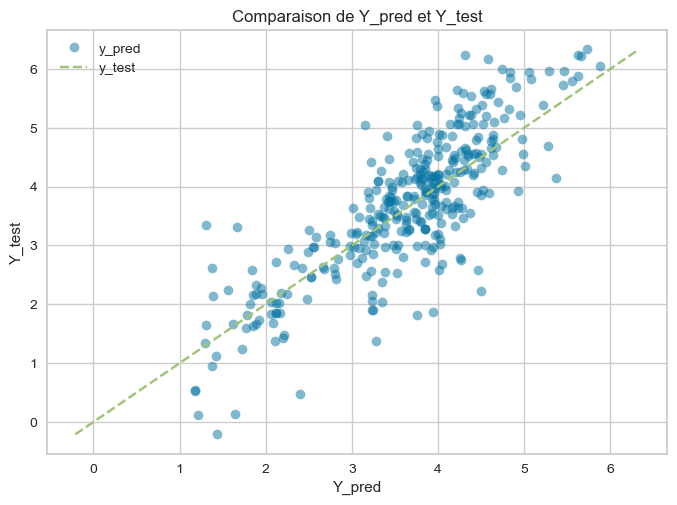

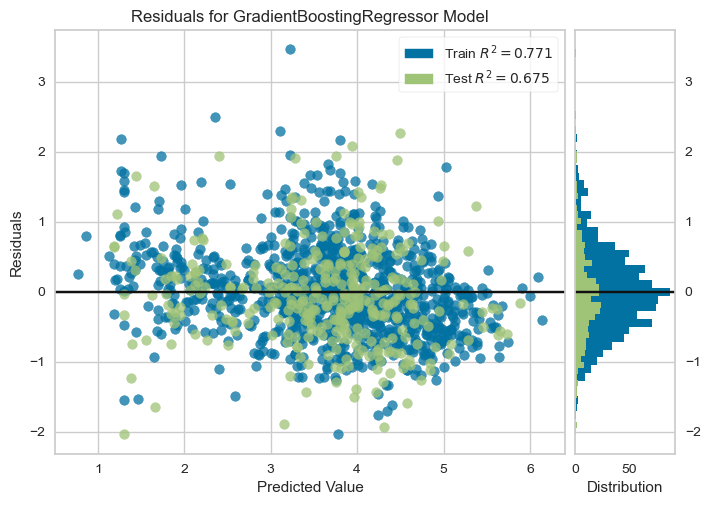

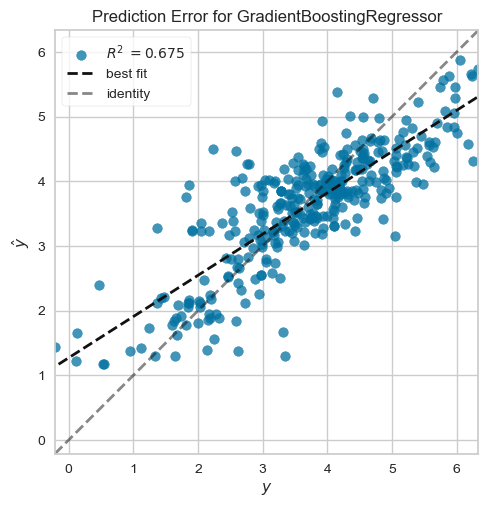

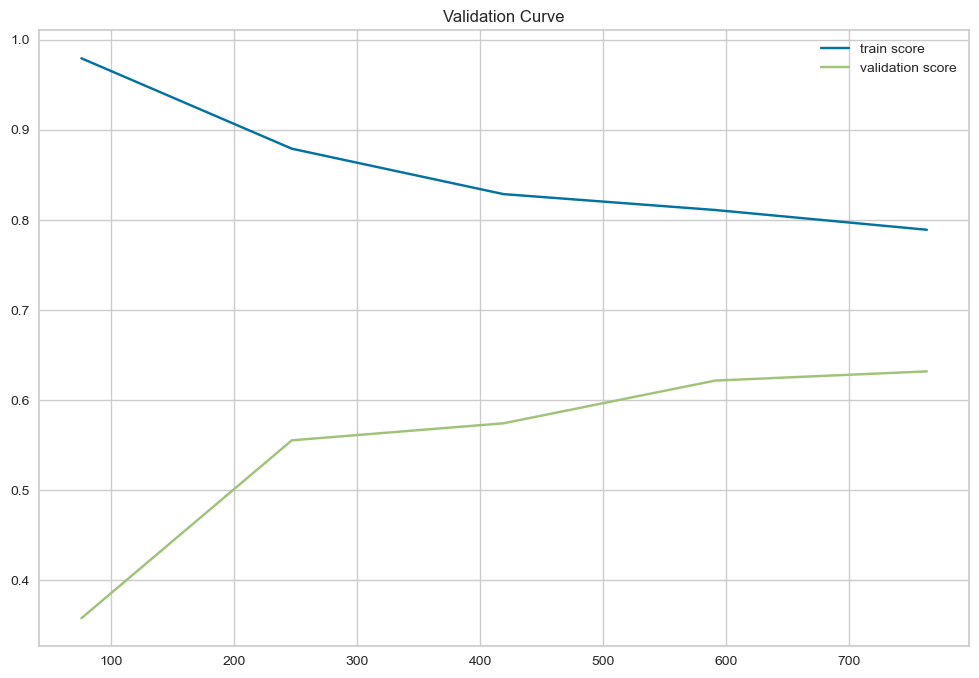

In [39]:
predic_plot(df_star,models['gradientboosting'],log=True,Outlier=False,standardisers=standardisers_1[2])

In [40]:
# Evaluation des modèles avec log et outliers
evaluation_model(df_star, models,log=True,Outlier=True)

VIF (facteur d'inflation de la variance)
                        feature       VIF
0                     YearBuilt  1.124374
1             NumberofBuildings  1.250406
2                SteamUse(kBtu)  1.244772
3              NaturalGas(kBtu)  1.143950
4                        Autres  1.141118
5                     Education  1.146261
6   EntertainmentPublicAssembly  1.125435
7              FoodSalesService  1.151466
8                    Healthcare  1.353308
9            LodgingResidential  1.223478
10                       Office  2.201915
11                        Other  1.208193
12                      Parking  1.924629
13             ReligiousWorship  1.011615
14                       Retail  1.154504
15            TechnologyScience  1.109357
16             WarehouseStorage  1.030728
17              ENERGYSTARScore  1.075246
18                      Outlier  2.334496


,Modèle,Standardisation,Log,Outlier,MAE,MSE,RMSE,R2_train,Time_train,R2_predict,Time_predict
8,gradientboosting,StandardScaler(),True,True,0.605,0.606,0.779,0.824,0.015731,0.756,0.000000
8,gradientboosting,RobustScaler(),True,True,0.606,0.607,0.779,0.824,0.000000,0.755,0.000000
8,gradientboosting,MinMaxScaler(),True,True,0.606,0.610,0.781,0.824,0.000000,0.754,0.000000
10,xgboost,RobustScaler(),True,True,0.605,0.632,0.795,0.980,0.000000,0.746,0.015666
9,forest,StandardScaler(),True,True,0.607,0.631,0.795,0.962,0.022146,0.746,0.009054
10,xgboost,StandardScaler(),True,True,0.605,0.632,0.795,0.980,0.000000,0.745,0.000000
10,xgboost,MinMaxScaler(),True,True,0.605,0.632,0.795,0.980,0.000000,0.745,0.000000
9,forest,MinMaxScaler(),True,True,0.607,0.633,0.796,0.962,0.015626,0.745,0.021996
9,forest,RobustScaler(),True,True,0.608,0.635,0.797,0.962,0.023180,0.744,0.000000
7,bagging,StandardScaler(),True,True,0.629,0.679,0.824,0.944,0.000000,0.727,0.000000


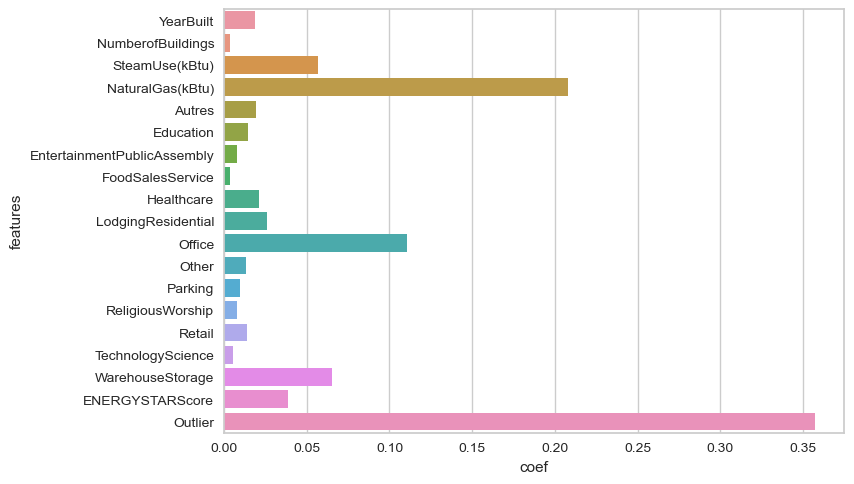

In [41]:
feature_importance(df_star,models['gradientboosting'],log=True,Outlier=True,coef=False)

R² train : 0.8239463359560671
R² predict: 0.7561337025927753
MAE : 0.6048066502750592
MSE : 0.6055769417475076
RMSE : 0.7781882431311254


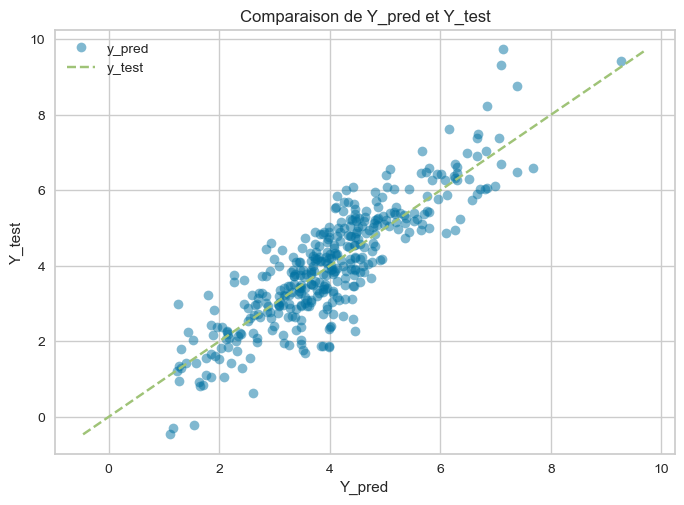

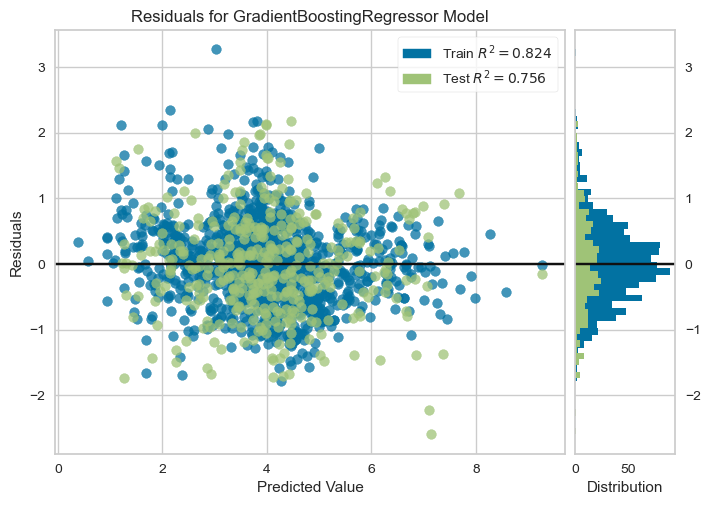

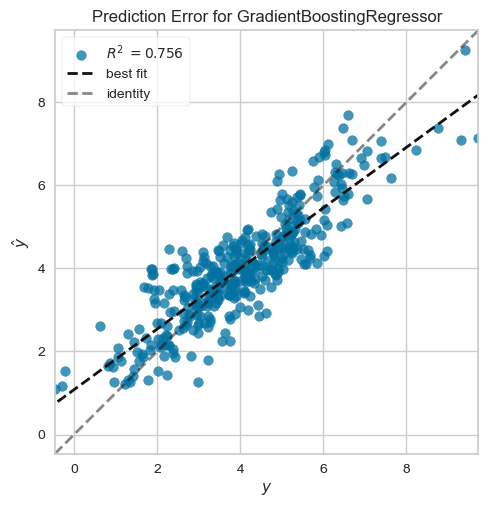

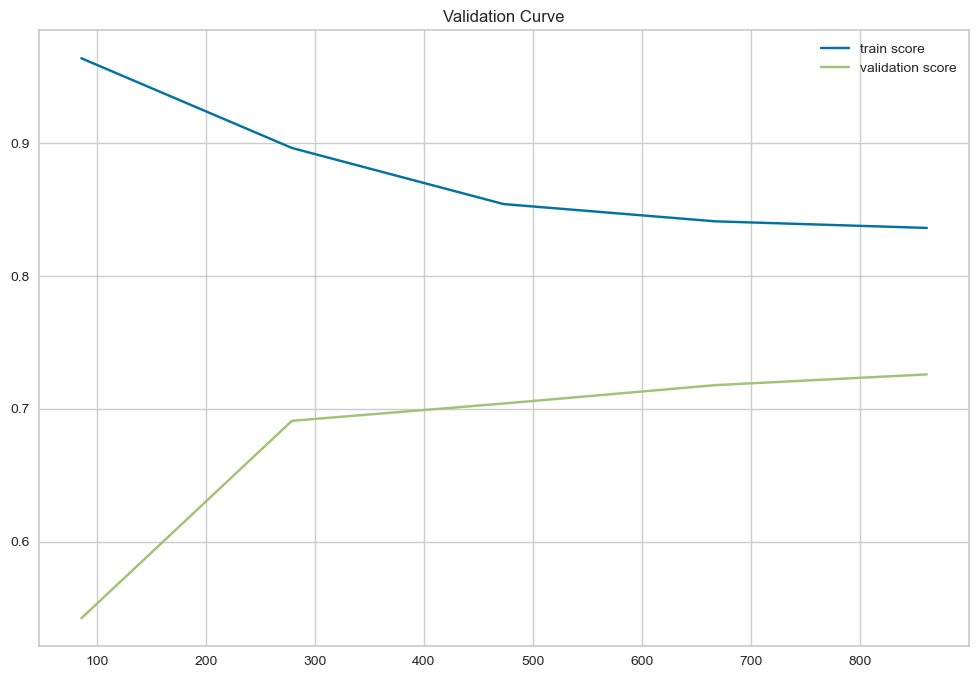

In [42]:
predic_plot(df_star,models['gradientboosting'],log=True,Outlier=True,standardisers=standardisers_1[2])

# Optimisation du modèle

In [54]:
dico_models3 = {
    'learning_rate': [0.01,0.02,0.03,0.04],
                  'subsample'    : [0.9, 0.5, 0.2, 0.1],
                  'n_estimators' : [100,500,1000, 1500],
                  'max_depth'    : [3,4,6]
}

Fitting 2 folds for each of 192 candidates, totalling 384 fits
Best Params:  {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 1000, 'subsample': 0.2}
Best GradientBoostingRegressor(learning_rate=0.01, max_depth=4, n_estimators=1000,
                          subsample=0.2)
R² train : 0.8518521218261078
R² predict: 0.7768356342941352
MAE : 0.5698756406301037
MSE : 0.5541692129171446
RMSE : 0.7444254246847999


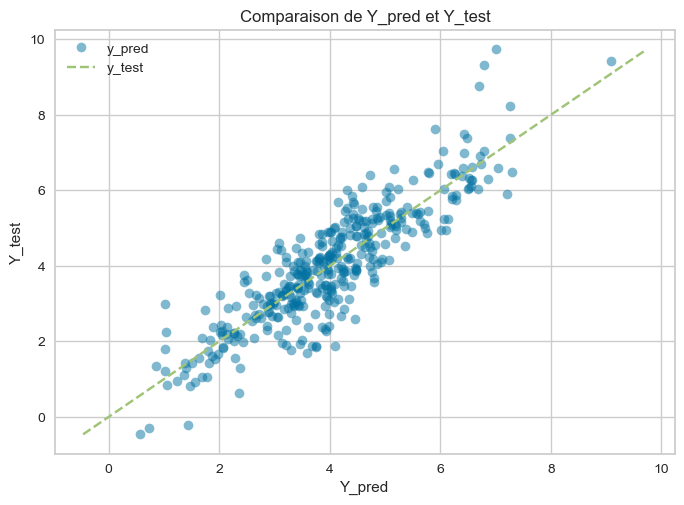

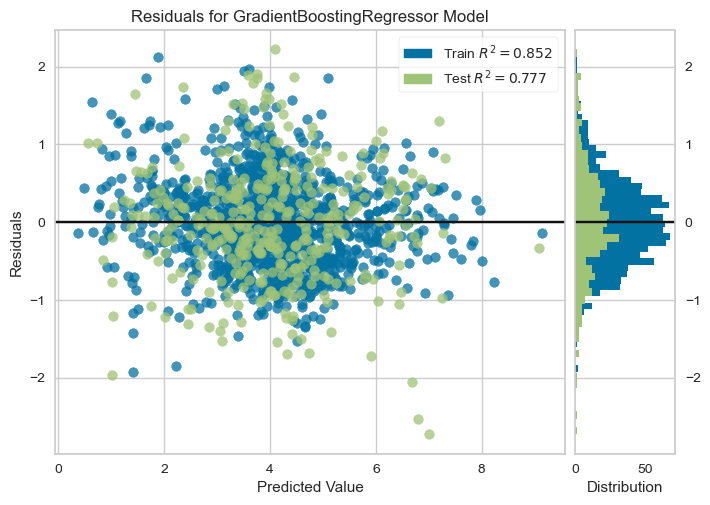

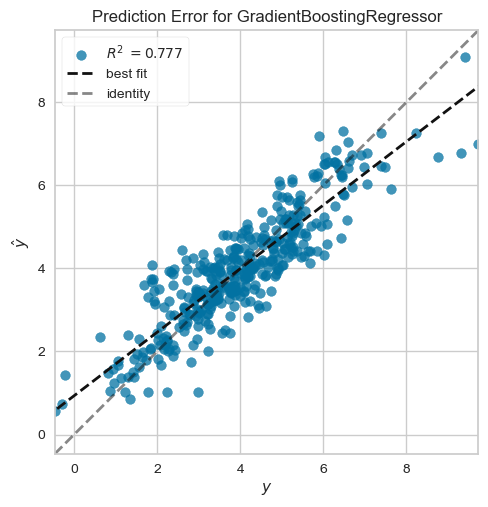

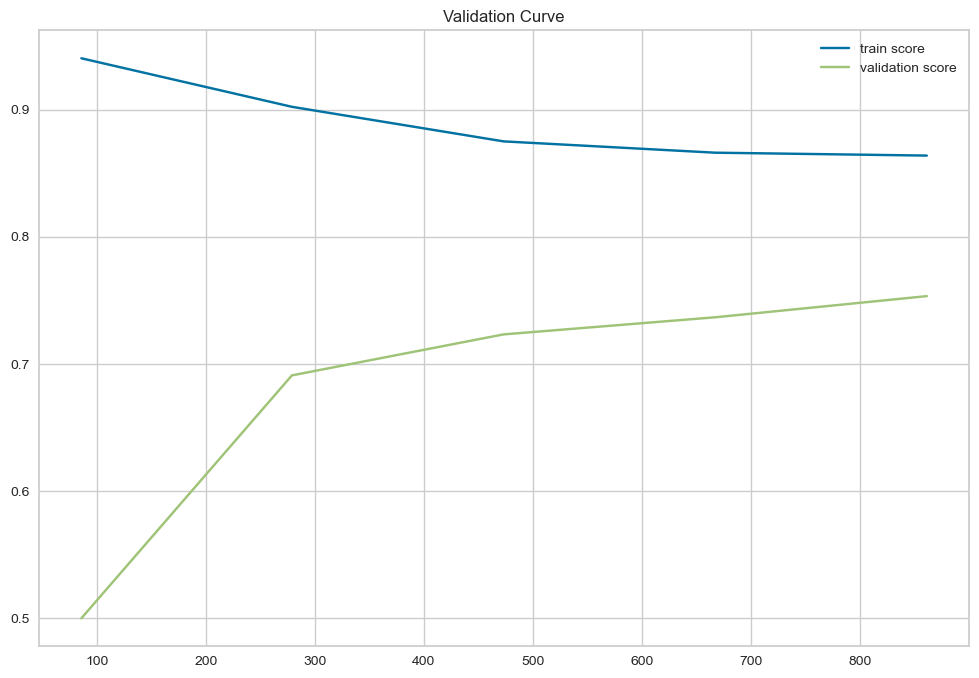

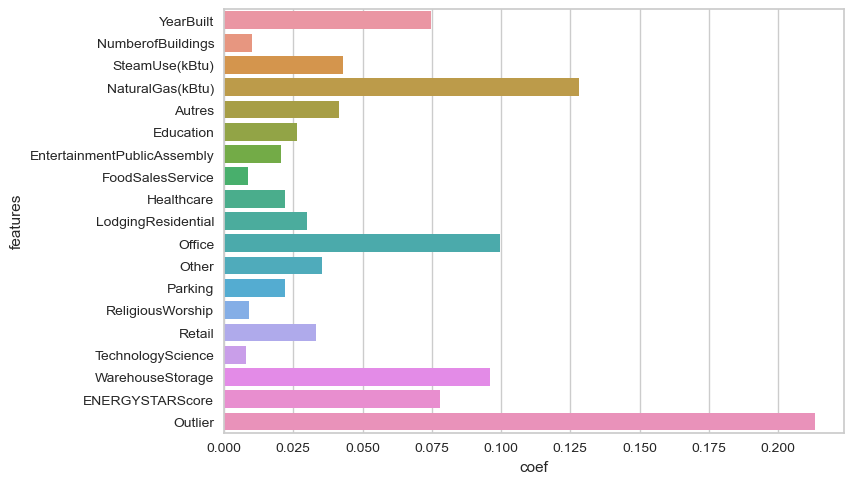

In [55]:
optimize_model(df_star,models['gradientboosting'],log=True,Outlier=True,standardisers=RobustScaler(),dico_search=dico_models3,coef=False)